## Background

This script is for estimating an updated WFH model for TM1.6.1. The [initial WFH model created for TM1.6.0](https://github.com/BayAreaMetro/travel-model-one/pull/63) was estimated using ACS 2021 data (and later updated to use ACS 2022 data) based on household income, home county, and industry. However, ACS and ACS PUMS data on WFH has the limitation that for workers who report WFH as their primary journey-to-work mode for the reference week, no distinct workplace (from home) is reported.

MTC staff looked at data from the [2023 Bay Area Travel Study (BATS)](https://mtc.ca.gov/tools-resources/survey-program) where workplace location was reported for all respondents who had a workplace, even if they worked from home on a survey day. We [found that the distances between work and home tended to be longer for people who worked from home](https://10ay.online.tableau.com/t/metropolitantransportationcommission/views/BATS-2023-SurveyDataViz--WeightedDataset_09112024_17261683633090/Dist-to-WorkTable), which is intuitve because a longer commute would incentive workers to WFH. However, the ACS-based WFH model implemented resulted in the reverse pattern.

Therefore, the goal here is to estimate a simple model using BATS 2023 data and a similar set of independent variables (to minimize implementation effort due to limited time available), but with the addition of a distance-to-work term included.

Asana task (internal): [Estimate WFH binomial logit model using BATS2023](https://app.asana.com/0/15119358130897/1208621825395379/f)

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import os
import pathlib

pd.options.display.max_rows = 1000

WORKSPACE_DIR = pathlib.Path("M:\\Development\\Travel Model One\\Estimation\\WFH_BATS_2023")

## 1. Prepare BATS 2023-2024 data

Also, read BATS 2018-2019 data as well to tabulate overall rate in a consistent way.

In [2]:
# default is C:/Users/username/Box
BOX_ROOT_DIR = pathlib.Path("C:/Users") / os.environ['USERNAME'] / "Box"
if (os.environ['USERNAME'] == 'lzorn'):
    BOX_ROOT_DIR = pathlib.Path("E:/Box")

BATS_2023_DATA_DIR = BOX_ROOT_DIR / "Modeling and Surveys" / "Surveys" / "Travel Diary Survey" / "Biennial Travel Diary Survey" / \
    "MTC_RSG_Partner Repository" / "5.Deliverables" / "Task 10 - Final Weighted and Expanded Data Files" / "WeightedDataset_11272024"

BATS_2019_DATA_DIR = pathlib.Path("M:\\Data\\HomeInterview\\Bay Area Travel Study 2018-2019\\Data\\" \
    "Final Version with Imputations\\Final Updated Dataset as of 10-18-2021\\RSG_HTS_Oct2021_bayarea")

### 1.1 Read households data for household income, home location

In [3]:
# read households
bats_2023_hhlds = pd.read_csv(BATS_2023_DATA_DIR / "hh.csv")
print(f"Read {len(bats_2023_hhlds):,} rows from \"{BATS_2023_DATA_DIR / 'hh.csv'}")

# print("\bats_2023_hhlds.dtypes:")
# print(bats_2023_hhlds.dtypes)

# select relevant variables
bats_2023_hhlds = bats_2023_hhlds[[
    'hh_id','home_county',
    'home_lat','home_lon',
    'income_imputed']]
bats_2023_hhlds.rename(columns={'income_imputed':'hhld_income_imputed'}, inplace=True)
bats_2023_hhlds['survey_year'] = 2023

bats_2019_hhlds = pd.read_csv(BATS_2019_DATA_DIR / "hh.tsv", sep='\t')
print(f"Read {len(bats_2019_hhlds):,} rows from \"{BATS_2019_DATA_DIR / 'hh.tsv'}")

# print("\bats_2019_hhlds.dtypes:")
# print(bats_2019_hhlds.dtypes)

# select relevant variables
bats_2019_hhlds = bats_2019_hhlds[[
    'hh_id','home_county_fips',
    'reported_home_lat', 'reported_home_lon']] # income_imputed is person variable now
# recode home_county consistently with BATS 2023
bats_2019_hhlds['home_county_fips'] = 6000 + bats_2019_hhlds['home_county_fips']
bats_2019_hhlds.rename(columns={
    'home_county_fips':'home_county',
    'reported_home_lat':'home_lat',
    'reported_home_lon':'home_lon'}, 
    inplace=True)
bats_2019_hhlds['survey_year'] = 2019

# combine
bats_hhlds = pd.concat([bats_2019_hhlds, bats_2023_hhlds]).reset_index(drop=True)

# add home_county_str
COUNTY_RECODE = {
    6001: 'Alameda',
    6013: 'ContraCosta',
    6041: 'Marin',
    6055: 'Napa',
    6075: 'SanFrancisco',
    6081: 'SanMateo',
    6085: 'SantaClara',
    6095: 'Solano',
    6097: 'Sonoma'
}
bats_hhlds['home_county_str'] = bats_hhlds.home_county.map(COUNTY_RECODE)
print(f"\n{bats_hhlds[['home_county_str','survey_year']].value_counts(dropna=False)}")
print(f"\n{bats_hhlds['survey_year'].value_counts(dropna=False)}")

# add dummies for income_imputed
homecounty_dummies = pd.get_dummies(data=bats_hhlds.home_county_str, prefix="home")
# combine Marin, Napa and Sonoma
homecounty_dummies['home_MarinNapaSonoma'] = homecounty_dummies.home_Marin + homecounty_dummies.home_Napa + homecounty_dummies.home_Sonoma
# combine Solano, Marin, Napa and Sonoma
homecounty_dummies['home_NorthBay'] = homecounty_dummies.home_Solano + homecounty_dummies.home_Marin + homecounty_dummies.home_Napa + homecounty_dummies.home_Sonoma

homecounty_dummies.drop(columns=['home_Marin','home_Napa','home_Sonoma'], inplace=True)
bats_hhlds = bats_hhlds.join(homecounty_dummies)


Read 8,258 rows from "E:\Box\Modeling and Surveys\Surveys\Travel Diary Survey\Biennial Travel Diary Survey\MTC_RSG_Partner Repository\5.Deliverables\Task 10 - Final Weighted and Expanded Data Files\WeightedDataset_11272024\hh.csv
Read 4,540 rows from "M:\Data\HomeInterview\Bay Area Travel Study 2018-2019\Data\Final Version with Imputations\Final Updated Dataset as of 10-18-2021\RSG_HTS_Oct2021_bayarea\hh.tsv

home_county_str  survey_year
SanFrancisco     2023           2585
                 2019           2171
Alameda          2023           1853
SantaClara       2023           1333
ContraCosta      2023            966
Alameda          2019            864
SantaClara       2019            727
Solano           2023            497
SanMateo         2023            417
Sonoma           2023            316
SanMateo         2019            256
ContraCosta      2019            194
Napa             2023            170
Sonoma           2019            148
Marin            2023            121
Sol

#### 1.1.1 Recode household income

In [4]:
# recode
INCOME_IMPUTED_2023_RECODE = {
    'Under $25,000'    : '000to025k',
    '$25,000-$49,999'  : '025to050k',
    '$50,000-$74,999'  : '050to075k',
    '$75,000-$99,999'  : '075to100k',
    '$100,000-$199,999': '100to200k',
    '$200,000 or more' : '200plusk'
}
bats_hhlds['hhld_income_imputed'] = bats_hhlds.hhld_income_imputed.map(INCOME_IMPUTED_2023_RECODE)

# add dummies for income_imputed
hhinc_dummies = pd.get_dummies(data=bats_hhlds.hhld_income_imputed, prefix="hhinc")
bats_hhlds = bats_hhlds.join(hhinc_dummies)

# recode to value
# TODO: this is crude, but I don't know that sampling a number in this range would be preferable?
# These are the weighted averages of household income from PUMS 2023, filtered to employed persons only
# via census-tools-for-planning\Analysis\investigateWorkFromHomeMergedPUMS.R
# See https://10ay.online.tableau.com/t/metropolitantransportationcommission/views/WFH_BATS_2023/2023PUMSIncome
INCOME_IMPUTED_NOMINAL_2023_RECODE = {
    '000to025k' : 11775.0,
    '025to050k':  35561.0,
    '050to075k':  62278.0,
    '075to100k':  86847.0,
    '100to200k': 144350.0,
    '200plusk' : 318930.0,
}
bats_hhlds['hhld_income_imputed_nominal'] = bats_hhlds.hhld_income_imputed.map(INCOME_IMPUTED_NOMINAL_2023_RECODE)
# these will be null for survey_year == 2019 since there's no hhld_income_imputed
bats_hhlds.loc[ bats_hhlds.survey_year==2019, 'hhld_income_imputed_nominal'] = np.nan
# convert from 2023 dollars to 2000 dollars
# https://github.com/BayAreaMetro/modeling-website/wiki/InflationAssumptions
DOLLARS_2000_TO_2023 = 1.88
bats_hhlds['hhld_income_imputed_nominal_2000d'] = bats_hhlds.hhld_income_imputed_nominal / DOLLARS_2000_TO_2023
bats_hhlds['ln_hhld_income_imputed_nominal_2000d'] = np.log(bats_hhlds.hhld_income_imputed_nominal_2000d)

### 1.2 Read person data for employment status, work location and industry

Filter to employed persons who have a recorded work location in the region.

In [5]:
# read persons
bats_2023_persons = pd.read_csv(BATS_2023_DATA_DIR / "person.csv")
print(f"Read {len(bats_2023_persons):,} rows from \"{BATS_2023_DATA_DIR / 'person.csv'}\"")

# print("\bats_2023_persons.dtypes:")
# print(bats_2023_persons.dtypes)

# select relevant variables
bats_2023_persons = bats_2023_persons[[
    'hh_id','person_id',
    'employment','work_lat','work_lon','work_in_region','work_county',
    'industry','industry_other']]
bats_2023_persons['survey_year'] = 2023

bats_2019_persons = pd.read_csv(BATS_2019_DATA_DIR / "person.tsv", sep='\t')
print(f"Read {len(bats_2019_persons):,} rows from \"{BATS_2019_DATA_DIR / 'person.tsv'}\"")

# print("\bats_2019_persons.dtypes:")
# print(bats_2019_persons.dtypes)

bats_2019_persons = bats_2019_persons[[
    'hh_id','person_id',
    'employment', 'work_lat','work_lon','work_county_fips',
    # no industry information
    'income_imputed'
]]
bats_2019_persons['survey_year'] = 2019
bats_2019_persons.rename(columns={'income_imputed':'income_imputed_person'}, inplace=True)
# print(f"bats_2019_person.income_imputed_person.value_counts():\n{bats_2019_persons.income_imputed_person.value_counts(dropna=False)}")
# add home_county_str
INCOME_IMPUTED_RECODE_2019 = {
    1: 'Under $25,000',
    2: '$25,000-$49,999',
    3: '$50,000-$74,999',
    4: '$75,000-$99,999',
    5: '$100,000-$149,999',
    6: '$150,000-$199,999',
    7: '$200,000-$249,999',
    8: '$250,000 or more',
    995: 'Missing'
}
bats_2019_persons['income_imputed_person'] = bats_2019_persons.income_imputed_person.map(INCOME_IMPUTED_RECODE_2019)
# print(f"bats_2019_person.income_imputed_person.value_counts():\n{bats_2019_persons.income_imputed_person.value_counts(dropna=False)}")

# recode work_county and work_in_region consistently with BATS 2023
bats_2019_persons['work_county_fips'] = 6000 + bats_2019_persons['work_county_fips']
bats_2019_persons.rename(columns={
    'work_county_fips':'work_county'}, 
    inplace=True)
bats_2019_persons['work_in_region'] = 1
bats_2019_persons.loc[ pd.isna(bats_2019_persons.work_county), 'work_in_region'] = 0
# print(f"bats_2019_persons.work_county:\n{bats_2019_persons.work_county.value_counts(dropna=False)}")

# put them together
bats_persons = pd.concat([bats_2019_persons, bats_2023_persons]).reset_index(drop=True)
# TODO: Include self-employed? (employment==3)
print("\nFiltering to: employment == 1 Employed full-time (paid) or 2 Employed part-time (paid) =>")
bats_persons = bats_persons.loc[bats_persons.employment.isin([1,2])]
print(f"{bats_persons.survey_year.value_counts()}")

# set variable for has_work_location
bats_persons['has_work_location'] = False
bats_persons.loc[pd.notna(bats_persons.work_lat) & pd.notna(bats_persons.work_lon), "has_work_location"] = True

print("\nWork in region vs has_work_location tabulation:")
print(bats_persons[["survey_year","work_in_region","has_work_location"]].value_counts(dropna=False))

# It looks like work_in_region==995 => has_work_location==False
# Drop work_in_region==0 and has_work_location==False
print("\nFiltering to: work_in_region==1 and has_work_location==True =>")
bats_persons = bats_persons.loc[(bats_persons.work_in_region == 1)&
                                (bats_persons.has_work_location==True)].reset_index(drop=True)
print(f"{bats_persons.survey_year.value_counts(dropna=False)}")

# add work_county_str and dummies
bats_persons['work_county_str'] = bats_persons.work_county.map(COUNTY_RECODE)
# add dummies for income_imputed
workcounty_dummies = pd.get_dummies(data=bats_persons.work_county_str, prefix="work")

bats_persons = bats_persons.join(workcounty_dummies)

Read 15,985 rows from "E:\Box\Modeling and Surveys\Surveys\Travel Diary Survey\Biennial Travel Diary Survey\MTC_RSG_Partner Repository\5.Deliverables\Task 10 - Final Weighted and Expanded Data Files\WeightedDataset_11272024\person.csv"
Read 9,795 rows from "M:\Data\HomeInterview\Bay Area Travel Study 2018-2019\Data\Final Version with Imputations\Final Updated Dataset as of 10-18-2021\RSG_HTS_Oct2021_bayarea\person.tsv"

Filtering to: employment == 1 Employed full-time (paid) or 2 Employed part-time (paid) =>
survey_year
2023    8374
2019    5953
Name: count, dtype: int64

Work in region vs has_work_location tabulation:
survey_year  work_in_region  has_work_location
2023         1               True                 5982
2019         1               True                 3187
             0               False                2762
2023         995             False                2328
             0               True                   64
2019         0               True                  

#### 1.2.1 Recode industry to TM1 categories

See https://github.com/BayAreaMetro/modeling-website/wiki/TazData

* `RETEMPN`: Retail trade employment (NAICS-based)
* `FPSEMPN`: Financial and professional services employment (NAICS-based)
* `HEREMPN`: Health, educational and recreational service employment (NAICS-based)
* `AGREMPN`: Agricultural and natural resources employment (NAICS-based)
* `MWTEMPN`: Manufacturing, wholesale trade and transportation employment (NAICS-based)
* `OTHEMPN`: Other employment (NAICS-based)

Also see [NAICS_to_EMPSIX.xlsx](https://github.com/BayAreaMetro/travel-model-one/blob/master/utilities/taz-data-baseyears/2015/Employment/NAICS_to_EMPSIX.xlsx)


In [6]:
INDUSTRY_RECODE = {
    1   : 'AGREMPN', # Agriculture, Forestry, Fishing, and Hunting
    2   : 'AGREMPN', # Mining, Quarrying, and Oil and Gas Extraction
    3   : 'MWTEMPN', # Utilities
    4   : 'OTHEMPN', # Construction
    5   : 'MWTEMPN', # Manufacturing
    6   : 'MWTEMPN', # Wholesale Trade
    7   : 'RETEMPN', # Retail Trade
    8   : 'MWTEMPN', # Transportation and Warehousing
    9   : 'OTHEMPN', # Information
    10  : 'FPSEMPN', # Finance and Insurance
    11  : 'FPSEMPN', # Real Estate and Rental and Leasing
    12  : 'FPSEMPN', # Professional, Scientific, and Technical Services
    13  : 'FPSEMPN', # Management of Companies and Enteprises
    14  : 'FPSEMPN', # Administrative and Support and Waste Management and Remediation Services
    15  : 'HEREMPN', # Educational Servies
    16  : 'HEREMPN', # Helath Care and Social Assitance
    17  : 'HEREMPN', # Arts, Entertainment, and Recreation
    18  : 'HEREMPN', # Accommodation and Food Services
    19  : 'OTHEMPN', # Other Services (except Public Administration)
    20  : 'OTHEMPN', # Public Administration
    # 995 : NA,   # Missing Response
    # 997 : NA,   # Other, please specify
}

bats_persons['empsix'] = bats_persons.industry.map(INDUSTRY_RECODE)
print("After recoding 'industry':")
print(bats_persons[['survey_year','empsix']].value_counts(dropna=False))

# try to resolve some of the remaining
bats_persons.industry_other = bats_persons.industry_other.str.lower()
bats_persons.industry_other = bats_persons.industry_other.str.strip()

INDUSTRY_OTHER_TERM_RECODE = {
    'technology'             : 'FPSEMPN',
    'biotechnology'          : 'FPSEMPN',
    'biotech'                : 'FPSEMPN',
    'biomedical'             : 'FPSEMPN',
    'tech'                   : 'FPSEMPN',
    'software'               : 'FPSEMPN',
    'security'               : 'FPSEMPN', # NAICS 561612
    'government'             : 'OTHEMPN',
    'judicial'               : 'OTHEMPN',
    'national park service'  : 'OTHEMPN',
    'law enforcement'        : 'OTHEMPN',
    'military'               : 'OTHEMPN',
    'library'                : 'OTHEMPN',
    'automotive'             : 'MWTEMPN',
    'nonprofit'              : 'HEREMPN',
    'non-profit'             : 'HEREMPN',
    'non profit'             : 'HEREMPN',
    'philanthropy'           : 'HEREMPN',
    'childcare'              : 'HEREMPN',
    'health'                 : 'HEREMPN',
    'fitness'                : 'HEREMPN',
    'school'                 : 'HEREMPN',
    'legal'                  : 'FPSEMPN',
    'law'                    : 'FPSEMPN',
    'attorney'               : 'FPSEMPN',
    'marketing'              : 'FPSEMPN',
    'hospitality'            : 'HEREMPN',
    'hotel'                  : 'HEREMPN',
    'e-commerce'             : 'RETEMPN',
    'ecommerce'              : 'RETEMPN',
}
# if any of these words appear, apply it
for term in INDUSTRY_OTHER_TERM_RECODE.keys():
    bats_persons.loc[pd.isna(bats_persons.empsix) & 
                     (bats_persons.industry_other.str.find(term) >=0), 'empsix'] = INDUSTRY_OTHER_TERM_RECODE[term]

# print("\nindustry_other for NA empsix:")
# print(bats_persons.loc[pd.isna(bats_persons.empsix),'industry_other'].value_counts(dropna=False))

print("\nAfter recoding 'industry_other':")
print(bats_persons[['survey_year','empsix']].value_counts(dropna=False))

print("\nFiltering out NaN industry for bats_2023:")
bats_persons = bats_persons.loc[ (bats_persons.survey_year==2019) | (pd.notna(bats_persons.empsix))]
print(f"{bats_persons['survey_year'].value_counts(dropna=False)}")

# add dummies for empsix
ind_dummies = pd.get_dummies(data=bats_persons.empsix, prefix="ind")
bats_persons = bats_persons.join(ind_dummies)

After recoding 'industry':
survey_year  empsix 
2019         NaN        3187
2023         HEREMPN    1886
             FPSEMPN    1379
             OTHEMPN    1107
             NaN         754
             MWTEMPN     604
             RETEMPN     211
             AGREMPN      41
Name: count, dtype: int64

After recoding 'industry_other':
survey_year  empsix 
2019         NaN        3187
2023         HEREMPN    1987
             FPSEMPN    1588
             OTHEMPN    1174
             MWTEMPN     619
             NaN         358
             RETEMPN     215
             AGREMPN      41
Name: count, dtype: int64

Filtering out NaN industry for bats_2023:
survey_year
2023    5624
2019    3187
Name: count, dtype: int64


### 1.3 Merge persons with households

In [7]:
# Merge with households
bats_persons = pd.merge(
    left=bats_persons,
    right=bats_hhlds,
    on=['hh_id','survey_year'],
    how='left',
    validate='many_to_one',
    indicator=True
)
# verify all person records have household information
assert all(bats_persons['_merge'] == 'both'), "Not all values in _merge are 'both'"
bats_persons.drop(columns=['_merge'],inplace=True)
# bats_persons.head()

### 1.4 Filter out persons where work location == home location

In [8]:
# If work location == home location, they don't have a work location outside of the home
# This isn't a modeled use case, so filter out
bats_persons['work_loc_is_home_loc'] = False
bats_persons.loc[(bats_persons.work_lon == bats_persons.home_lon) &
                 (bats_persons.work_lat == bats_persons.home_lat),
                 'work_loc_is_home_loc'] = True
print(f"bats_persons[['survey_year','work_loc_is_home_loc']].value_counts()=\n{bats_persons[['survey_year','work_loc_is_home_loc']].value_counts()}")

print("\nFiltering to: work_loc_is_home_loc==False =>")
bats_persons = bats_persons.loc[bats_persons.work_loc_is_home_loc==False].reset_index(drop=True)
print(f"{bats_persons['survey_year'].value_counts()}")


bats_persons[['survey_year','work_loc_is_home_loc']].value_counts()=
survey_year  work_loc_is_home_loc
2023         False                   5433
2019         False                   3179
2023         True                     191
2019         True                       8
Name: count, dtype: int64

Filtering to: work_loc_is_home_loc==False =>
survey_year
2023    5433
2019    3179
Name: count, dtype: int64


#### 1.4.1 Attach TM1 TAZ for home location and work location

In [9]:
TM1_SHAPEFILE = pathlib.Path("M:\\Data\\GIS layers\\TM1_taz\\bayarea_rtaz1454_rev1_WGS84.shp")
taz_shape_gdf = gpd.read_file(TM1_SHAPEFILE)
print(f"Read {len(taz_shape_gdf):,} rows from '{TM1_SHAPEFILE}'")
print(taz_shape_gdf.crs)

# spatial join home and work locations with TAZ
nrows = len(bats_persons)
for loc in ['home','work']:
    loc_geometry = [shapely.geometry.Point(xy) for xy in zip(bats_persons[f'{loc}_lon'],bats_persons[f'{loc}_lat'])]
    bats_persons_gdf = gpd.GeoDataFrame(
        data=bats_persons[['hh_id','person_id']], 
        geometry=loc_geometry,
        crs='EPSG:4326')

    assert(nrows == len(bats_persons_gdf))
    bats_persons_gdf = gpd.sjoin_nearest(
        bats_persons_gdf, 
        taz_shape_gdf, 
        how='left')
    assert(nrows == len(bats_persons_gdf))

    print(f"Of {len(bats_persons_gdf):,} rows, {len(bats_persons_gdf.loc[pd.isna(bats_persons_gdf.TAZ1454)]):,}" + \
      f" failed the TAZ spatial join for {loc}")

    # add back to bats_persons
    bats_persons_gdf.rename(columns={'TAZ1454':f'{loc}_TAZ1454'}, inplace=True)
    bats_persons = pd.merge(
        left=bats_persons,
        right=bats_persons_gdf[['hh_id','person_id',f'{loc}_TAZ1454']],
        how='left',
        on=['hh_id','person_id']
    )

# note: I visually checked that this looks reasonable

Read 1,454 rows from 'M:\Data\GIS layers\TM1_taz\bayarea_rtaz1454_rev1_WGS84.shp'
EPSG:4326


e:\conda\envs\NetworkWrangler2024\lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Of 8,612 rows, 0 failed the TAZ spatial join for home


e:\conda\envs\NetworkWrangler2024\lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Of 8,612 rows, 0 failed the TAZ spatial join for work


#### 1.4.2 Attach home-to-work distance based on TAZs

`NONMOTSKM_DIST.csv` is an export of the distance skims generated by [NonMotorizedSkims.job](https://github.com/BayAreaMetro/travel-model-one/blob/master/model-files/scripts/skims/NonMotorizedSkims.job) for the model run `2023_TM161_IPA_07`, but this skim does not include any link restrictions so it should be shortest-link-path.

In [10]:
DIST_SKIM_FILE = WORKSPACE_DIR / "NONMOTSKM_DIST.csv"
dist_skim_df = pd.read_csv(DIST_SKIM_FILE, header=None, names=["home_TAZ1454","work_TAZ1454","ones","distance_home_to_work"])
print(f"Read {len(dist_skim_df):,} rows from '{DIST_SKIM_FILE}'")
dist_skim_df.drop(columns=["ones"], inplace=True)

dist_skim_df.head()

# join to bats_persons for home-to-work distance
bats_persons = pd.merge(
    left=bats_persons,
    right=dist_skim_df,
    how='left',
    on=['home_TAZ1454','work_TAZ1454'],
    indicator=True,
    validate='many_to_one'
)
# verify all person records have household information
assert all(bats_persons['_merge'] == 'both'), "Not all values in _merge are 'both'"
bats_persons.drop(columns=['_merge'],inplace=True)

# add ln_distance_home_to_work
bats_persons['ln_distance_home_to_work'] = np.log(bats_persons.distance_home_to_work)

Read 2,175,625 rows from 'M:\Development\Travel Model One\Estimation\WFH_BATS_2023\NONMOTSKM_DIST.csv'


### 1.5 Read day data and merge with persons/households
Filter to Tuesdays, Wednesdays and Thursday

Read 89,112 rows from "E:\Box\Modeling and Surveys\Surveys\Travel Diary Survey\Biennial Travel Diary Survey\MTC_RSG_Partner Repository\5.Deliverables\Task 10 - Final Weighted and Expanded Data Files\WeightedDataset_11272024\day.csv"
bats_2023_day.day_weight.sum(): 7,326,906.961125877
Read 35,070 rows from "M:\Data\HomeInterview\Bay Area Travel Study 2018-2019\Data\Final Version with Imputations\Final Updated Dataset as of 10-18-2021\RSG_HTS_Oct2021_bayarea\day.tsv"
bats_2019_day.day_weight.sum(): 6,036,992.655113575

Filtering to: travel_dow is Tuesday, Wednesday or Thursday =>
survey_year
2023    39844
2019    15030
Name: count, dtype: int64

Merging with employed persons with work locations
survey_year  _merge    
2023         both          14791
2019         both           9510
             right_only        9
Name: count, dtype: int64

After dropping _merge != both: 
survey_year
2023    14791
2019     9510
Name: count, dtype: int64


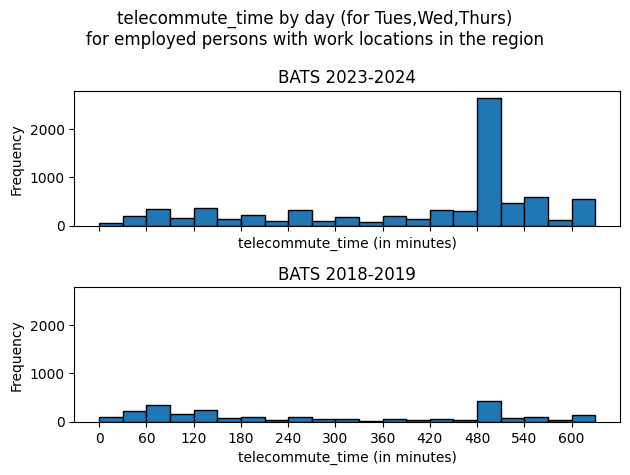

In [11]:
# read day data for day of week and telecommute time spent
bats_2023_day = pd.read_csv(BATS_2023_DATA_DIR / "day.csv")
print(f"Read {len(bats_2023_day):,} rows from \"{BATS_2023_DATA_DIR / 'day.csv'}\"")

# print("\bats_2023_day.dtypes:")
# print(bats_2023_day.dtypes)

# select relevant variables
bats_2023_day = bats_2023_day[[
    'hh_id','person_id','day_num',
    'travel_date','travel_dow',
    'telecommute_time','day_weight']]
bats_2023_day['survey_year'] = 2023
print(f"bats_2023_day.day_weight.sum(): {bats_2023_day.day_weight.sum():,}")

bats_2019_day = pd.read_csv(BATS_2019_DATA_DIR / "day.tsv", sep="\t")
print(f"Read {len(bats_2019_day):,} rows from \"{BATS_2019_DATA_DIR / 'day.tsv'}\"")

# print("\bats_2019_day.dtypes:")
# print(bats_2019_day.dtypes)

# select relevant variables
bats_2019_day = bats_2019_day[[
    'hh_id','person_id','day_num',
    'travel_date','travel_date_dow',
    'telework_time','daywt_alladult_wkday']]
bats_2019_day['survey_year'] = 2019
bats_2019_day.rename(columns={
    'travel_date_dow':'travel_dow',
    'telework_time':'telecommute_time',
    'daywt_alladult_wkday':'day_weight'
}, inplace=True)
print(f"bats_2019_day.day_weight.sum(): {bats_2019_day.day_weight.sum():,}")

# combine
bats_day = pd.concat([bats_2019_day, bats_2023_day]).reset_index(drop=True)

print("\nFiltering to: travel_dow is Tuesday, Wednesday or Thursday =>")
bats_day = bats_day.loc[bats_day.travel_dow.isin([2,3,4])]
print(f"{bats_day['survey_year'].value_counts(dropna=False)}")

# This didn't do anything; holidays were already excluded
# import holidays
# print("\nFiltering to exclude holidays.US()")
# bats_day = bats_day.loc[~bats_day.travel_date.isin(holidays.US())]
# print(f" => {len(bats_day):,} rows")

print("\nMerging with employed persons with work locations")
bats_day = pd.merge(
    left=bats_day,
    right=bats_persons,
    on=['survey_year','person_id','hh_id'],
    how='right', # keep only days for employed persons with work locations
    validate='many_to_one',
    indicator=True
)
# verify all day records have persons/household information
print(f"{bats_day[['survey_year','_merge']].value_counts(dropna=False)}")

# there are 9 records in the 2019 dataset that don't merge -- drop them
bats_day = bats_day.loc[bats_day._merge == 'both'].reset_index(drop=True)
print(f"\nAfter dropping _merge != both: \n{bats_day['survey_year'].value_counts(dropna=False)}")

# Plot telecommute_time distribution
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
fig.suptitle('telecommute_time by day (for Tues,Wed,Thurs)\nfor employed persons with work locations in the region')
# 2023
axs[0].hist(bats_day.telecommute_time.loc[(bats_day.survey_year==2023) & (bats_day.telecommute_time>0)], 
         bins=list(range(0,660,30)),
         edgecolor='black')
axs[0].set_title('BATS 2023-2024')
axs[0].set_xlabel('telecommute_time (in minutes)')
axs[0].set_xticks(list(range(0,660,60)))
axs[0].set_ylabel('Frequency')

# 2019
axs[1].hist(bats_day.telecommute_time.loc[(bats_day.survey_year==2019) & (bats_day.telecommute_time>0)], 
         bins=list(range(0,660,30)),
         edgecolor='black')
axs[1].set_title('BATS 2018-2019')
axs[1].set_xlabel('telecommute_time (in minutes)')
axs[1].set_xticks(list(range(0,660,60)))
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 1.6 Read trips data and filter to complete days
Summarize to the day level and flag if work trip was made

In [12]:
# read day data for day of week and telecommute time spent
bats_2023_trip = pd.read_csv(
    BATS_2023_DATA_DIR / "trip.csv",
    usecols=[
    'hh_id','person_id','day_num','trip_id',
    'd_purpose_category','day_is_complete'])
bats_2023_trip['survey_year'] = 2023
print(f"Read {len(bats_2023_trip):,} rows from \"{BATS_2023_DATA_DIR / 'trip.csv'}\"")

# print("bats_2023_trip.dtypes:")
# print(bats_2023_trip.dtypes)

bats_2019_trip = pd.read_csv(
    BATS_2019_DATA_DIR / "trip.tsv",
    sep="\t",
    usecols=[
        'hh_id','person_id','day_num','trip_id',
        'd_purpose_category', 'd_purpose_category_imputed'
    ]
)
bats_2019_trip['survey_year'] = 2019
# TODO: For 2019, assume day_is_complete=1
bats_2019_trip['day_is_complete'] = 1
print(f"Read {len(bats_2019_trip):,} rows from \"{BATS_2019_DATA_DIR / 'trip.tsv'}\"")

# use d_purpose_category_imputed when missing
bats_2019_trip.loc[(bats_2019_trip.d_purpose_category == -9998) & 
                   pd.notna(bats_2019_trip.d_purpose_category_imputed),
                    'd_purpose_category' ] = bats_2019_trip.d_purpose_category_imputed
bats_2019_trip.drop(columns='d_purpose_category_imputed', inplace=True)

# print("bats_2019_trip.dtypes:")
# print(bats_2019_trip.dtypes)

# combine
bats_trip = pd.concat([bats_2019_trip, bats_2023_trip]).reset_index(drop=True)

# filter to day_is_complete==1
print("\nFiltering to day_is_complete==1 =>")
bats_trip = bats_trip.loc[bats_trip.day_is_complete==1].reset_index(drop=True)
print(f"{bats_trip['survey_year'].value_counts(dropna=False)}")

# create dummy for work trip based on d_purpose_category
# print(bats_trip[['survey_year','d_purpose_category']].value_counts(dropna=False))
bats_trip['made_work_trip'] = 0
bats_trip.loc[bats_trip.d_purpose_category==2, 'made_work_trip'] = 1

# summarize to household/person/day to count work trips and total trips
bats_trip = bats_trip.groupby(by=['survey_year','hh_id','person_id','day_num']).agg(
    num_trips      = pd.NamedAgg(column='trip_id', aggfunc='count'),
    made_work_trip = pd.NamedAgg(column='made_work_trip', aggfunc='max')
).reset_index(drop=False)

print("\nmade_work_trip tabulation:")
print(bats_trip[['survey_year','made_work_trip']].value_counts(dropna=False))

print("\nbats_trip.dtypes:")
print(bats_trip.dtypes)

Read 365,831 rows from "E:\Box\Modeling and Surveys\Surveys\Travel Diary Survey\Biennial Travel Diary Survey\MTC_RSG_Partner Repository\5.Deliverables\Task 10 - Final Weighted and Expanded Data Files\WeightedDataset_11272024\trip.csv"
Read 188,492 rows from "M:\Data\HomeInterview\Bay Area Travel Study 2018-2019\Data\Final Version with Imputations\Final Updated Dataset as of 10-18-2021\RSG_HTS_Oct2021_bayarea\trip.tsv"

Filtering to day_is_complete==1 =>
survey_year
2023    335713
2019    188492
Name: count, dtype: int64

made_work_trip tabulation:
survey_year  made_work_trip
2023         0                 51207
2019         0                 18876
2023         1                 11884
2019         1                 11395
Name: count, dtype: int64

bats_trip.dtypes:
survey_year       int64
hh_id             int64
person_id         int64
day_num           int64
num_trips         int64
made_work_trip    int64
dtype: object


### 1.7 Join trips information to day dataset

In [13]:
# Here, we want an inner join because we only want employed persons with work locations
# But we also only want days where the day_is_complete
bats_day = pd.merge(
    left=bats_day,
    right=bats_trip,
    on=['survey_year','hh_id','person_id','day_num'],
    how='inner',
    validate='one_to_one'
)
print(f"After merging with trips data (which removes days which are not complete), bats_day:")
print(f"{bats_day['survey_year'].value_counts()}")

After merging with trips data (which removes days which are not complete), bats_day:
survey_year
2023    13008
2019     8976
Name: count, dtype: int64


### 1.8 Handle days where a person WFH *and* goes to work


Filtering to (telecommute > 0) OR (made_work_trip==1) =>
survey_year
2023    10561
2019     7379
Name: count, dtype: int64


E:\temp\ipykernel_36956\1837660257.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()


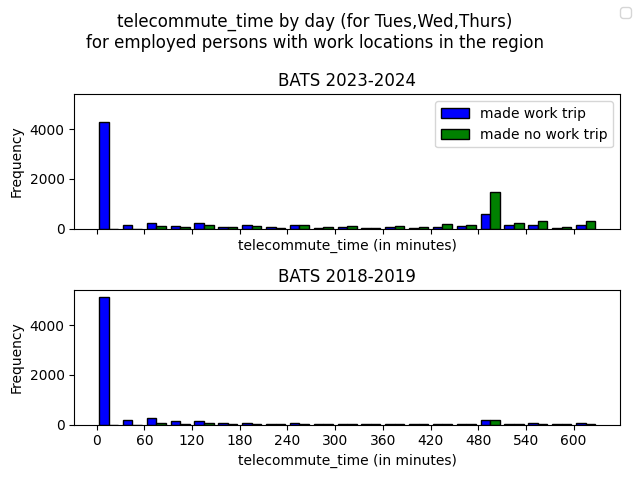


wfh vs goes to work:
survey_year  wfh  made_work_trip
2019         0    1                 5190
2023         0    1                 4254
             1    0                 3731
                  1                 2576
2019         1    1                 1462
                  0                  727
Name: count, dtype: int64

After converting wfh=>0 if made_work_trip==1:
survey_year  made_work_trip  wfh
2023         1               0      6830
2019         1               0      6652
2023         0               1      3731
2019         0               1       727
Name: count, dtype: int64


In [14]:
bats_day.head()
# remove days where the person neither went to work nor telecommuted
# TODO: I'm requiring telecommute_minutes >= 60 to count as working
MIN_WORK_TIME = 60

print("\nFiltering to (telecommute > 0) OR (made_work_trip==1) =>")
bats_day = bats_day.loc[(bats_day.telecommute_time >= MIN_WORK_TIME)|(bats_day.made_work_trip==1)].reset_index(drop=True)
print(f"{bats_day['survey_year'].value_counts(dropna=False)}")

# Plot telecommute_time distribution by made_work_trip
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
fig.suptitle('telecommute_time by day (for Tues,Wed,Thurs)\nfor employed persons with work locations in the region')
fig.legend()
# 2023
axs[0].hist([
        bats_day.loc[(bats_day.made_work_trip==1)&(bats_day.survey_year==2023)]['telecommute_time'], 
        bats_day.loc[(bats_day.made_work_trip==0)&(bats_day.survey_year==2023)]['telecommute_time']
    ],
    bins=list(range(0,660,30)),
    color=['blue','green'],
    label=['made work trip','made no work trip'],
    edgecolor='black')
axs[0].set_title('BATS 2023-2024')
axs[0].set_xlabel('telecommute_time (in minutes)')
axs[0].set_xticks(list(range(0,660,60)))
axs[0].set_ylabel('Frequency')
axs[0].legend(loc="upper right")

# 2019
axs[1].hist([
        bats_day.loc[(bats_day.made_work_trip==1)&(bats_day.survey_year==2019)]['telecommute_time'], 
        bats_day.loc[(bats_day.made_work_trip==0)&(bats_day.survey_year==2019)]['telecommute_time']
    ],
    bins=list(range(0,660,30)),
    color=['blue','green'],
    label=['made work trip','made no work trip'],
    edgecolor='black')
axs[1].set_title('BATS 2018-2019')
axs[1].set_xlabel('telecommute_time (in minutes)')
axs[1].set_xticks(list(range(0,660,60)))
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


bats_day['wfh'] = 0
bats_day.loc[bats_day.telecommute_time > 0, 'wfh'] = 1
print(f"\nwfh vs goes to work:\n{bats_day[['survey_year','wfh','made_work_trip']].value_counts(dropna=False)}")


#######################

# The travel model doesn't currently really represent people who make work trips *and* WFH within the same day
# Hence the forumlation of this as binary choice model.
# two options: 
#  1) if they go to work, then they didn't WFH (even if they did both)
#  2) if they go to work and WFH then drop the record
# => Going with option 1

# if they made a work trip, change wfh to 0
bats_day.loc[ (bats_day.made_work_trip==1) & (bats_day.wfh == 1), 'wfh' ] = 0
print(f"\nAfter converting wfh=>0 if made_work_trip==1:\n{bats_day[['survey_year','made_work_trip','wfh']].value_counts(dropna=False)}")

# option 2:
# bats_day = bats_day.loc[bats_day.wfh + bats_day.made_work_trip == 1]
# print("\nFiltering out wfh==1 AND made_work_trip==1")
# print(f"wfh vs goes to work:\n{bats_day[['wfh','made_work_trip']].value_counts(dropna=False)}")

### 1.9 Save estimation data

In [15]:
ESTIMATION_FILE = WORKSPACE_DIR / "bats_day.csv"
bats_day.to_csv(ESTIMATION_FILE, index=False)
print(f"Wrote {len(bats_day):,} rows to {ESTIMATION_FILE}")

Wrote 17,940 rows to M:\Development\Travel Model One\Estimation\WFH_BATS_2023\bats_day.csv


## 2. Estimate some models
### 2.1 Constant only

In [16]:
# constants only model - 2023
constant_formula = 'wfh ~ 1'
mod = smf.mnlogit(formula=constant_formula, data=bats_day.loc[bats_day.survey_year==2023])
res = mod.fit()
print(res.summary())

# constants only model - 2019
mod = smf.mnlogit(formula=constant_formula, data=bats_day.loc[bats_day.survey_year==2019])
res = mod.fit()
print(res.summary())

# Filter to 2023 for following models
bats_day = bats_day.loc[bats_day.survey_year==2023].reset_index(drop=False)

Optimization terminated successfully.
         Current function value: 0.649454
         Iterations 4
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                10561
Model:                        MNLogit   Df Residuals:                    10560
Method:                           MLE   Df Model:                            0
Date:                Mon, 16 Dec 2024   Pseudo R-squ.:               9.614e-11
Time:                        13:54:52   Log-Likelihood:                -6858.9
converged:                       True   LL-Null:                       -6858.9
Covariance Type:            nonrobust   LLR p-value:                       nan
     wfh=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6046      0.020    -29.701      0.000      -0.645      -0.565
Optimization terminated succe

### 2.2 Add distance term

In [17]:
# add distance term
distance_formula = constant_formula + ' + distance_home_to_work'
mod = smf.mnlogit(formula=distance_formula, data=bats_day)
res = mod.fit()
print(res.summary())

distance_ln_formula = constant_formula + ' + ln_distance_home_to_work'
mod = smf.mnlogit(formula=distance_ln_formula, data=bats_day)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.640652
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                10561
Model:                        MNLogit   Df Residuals:                    10559
Method:                           MLE   Df Model:                            1
Date:                Mon, 16 Dec 2024   Pseudo R-squ.:                 0.01355
Time:                        13:54:57   Log-Likelihood:                -6765.9
converged:                       True   LL-Null:                       -6858.9
Covariance Type:            nonrobust   LLR p-value:                 2.486e-42
                wfh=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.8963      0.030    -29.822      0.000      -0.955      -0.

### 2.2 Add income

In [18]:
# leave out hhinc_000to025k as reference
income_cat_formula = distance_formula + ' + hhinc_025to050k + hhinc_050to075k + hhinc_075to100k + hhinc_100to200k + hhinc_200plusk'
mod = smf.mnlogit(formula=income_cat_formula, data=bats_day)
res = mod.fit()
print(res.summary())

income_nominal_formula = distance_formula + ' + hhld_income_imputed_nominal_2000d'
mod = smf.mnlogit(formula=income_nominal_formula, data=bats_day)
res = mod.fit()
print(res.summary())

income_ln_nominal_formula = distance_formula + ' + ln_hhld_income_imputed_nominal_2000d'
mod = smf.mnlogit(formula=income_ln_nominal_formula, data=bats_day)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.633061
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                10561
Model:                        MNLogit   Df Residuals:                    10554
Method:                           MLE   Df Model:                            6
Date:                Mon, 16 Dec 2024   Pseudo R-squ.:                 0.02524
Time:                        13:55:01   Log-Likelihood:                -6685.8
converged:                       True   LL-Null:                       -6858.9
Covariance Type:            nonrobust   LLR p-value:                 9.882e-72
                  wfh=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.3839      0.142     -9.778      0.000      -1.661   

### 2.3 Add industry as dummy variables

Leave out `ind_FPSEMPN` as reference.

In [19]:
for distance in ['linear','ln']:
    for hhinc in ['linear','ln']:
        my_formula = constant_formula + '+ ind_AGREMPN + ind_HEREMPN + ind_MWTEMPN + ind_OTHEMPN + ind_RETEMPN'
        my_formula += ' + distance_home_to_work'        if distance == 'linear' else ' + ln_distance_home_to_work'
        my_formula += ' + income_imputed_nominal_2000d' if hhinc == 'linear'    else ' + ln_hhld_income_imputed_nominal_2000d'
        try:
            mod = smf.mnlogit(formula=my_formula, data=bats_day)
            res = mod.fit()
            print(res.summary())
        except Exception as inst:
            print(f"Exception caught: {inst}")


Exception caught: Error evaluating factor: NameError: name 'income_imputed_nominal_2000d' is not defined
    wfh ~ 1+ ind_AGREMPN + ind_HEREMPN + ind_MWTEMPN + ind_OTHEMPN + ind_RETEMPN + distance_home_to_work + income_imputed_nominal_2000d
                                                                                                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Optimization terminated successfully.
         Current function value: 0.626319
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                10561
Model:                        MNLogit   Df Residuals:                    10553
Method:                           MLE   Df Model:                            7
Date:                Mon, 16 Dec 2024   Pseudo R-squ.:                 0.03562
Time:                        13:55:05   Log-Likelihood:                -6614.6
converged:                       True   LL-Null

### 2.4 Segment by industry

In [20]:
# segment by Industry
EMPSIX_VALS = sorted(set(INDUSTRY_RECODE.values()))
print(EMPSIX_VALS)

for industry in EMPSIX_VALS:
    print(f"--------------------- Industry segment {industry} -----------------------------------------------------------------")
    for distance in ['linear','ln']:
        for hhinc in ['linear','ln']:
            my_formula = constant_formula
            my_formula += ' + distance_home_to_work'        if distance == 'linear' else ' + ln_distance_home_to_work'
            my_formula += ' + income_imputed_nominal_2000d' if hhinc == 'linear'    else ' + ln_hhld_income_imputed_nominal_2000d'
            try:
                mod = smf.mnlogit(formula=my_formula, data=bats_day.loc[bats_day.empsix == industry])
                res = mod.fit()
                print(res.summary())
            except Exception as inst:
                print(f"Exception caught: {inst}")


['AGREMPN', 'FPSEMPN', 'HEREMPN', 'MWTEMPN', 'OTHEMPN', 'RETEMPN']
--------------------- Industry segment AGREMPN -----------------------------------------------------------------
Exception caught: Error evaluating factor: NameError: name 'income_imputed_nominal_2000d' is not defined
    wfh ~ 1 + distance_home_to_work + income_imputed_nominal_2000d
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Optimization terminated successfully.
         Current function value: 0.497240
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                   70
Model:                        MNLogit   Df Residuals:                       67
Method:                           MLE   Df Model:                            2
Date:                Mon, 16 Dec 2024   Pseudo R-squ.:                0.006320
Time:                        13:55:14   Log-Likelihood:                -34.807
conve

### 2.5 Add home county as dummy variables
Keep `home_Solano` as reference.

In [21]:
industry_dummy_formula = constant_formula + ' + ind_AGREMPN + ind_HEREMPN + ind_MWTEMPN + ind_OTHEMPN + ind_RETEMPN'
home_county_dummy_formula = industry_dummy_formula + ' + home_Alameda + home_ContraCosta + home_MarinNapaSonoma + home_SanFrancisco + home_SanMateo + home_SantaClara'
for distance in ['linear','ln']:
    for hhinc in ['linear','ln']:
        my_formula = home_county_dummy_formula
        my_formula += ' + distance_home_to_work'        if distance == 'linear' else ' + ln_distance_home_to_work'
        my_formula += ' + income_imputed_nominal_2000d' if hhinc == 'linear'    else ' + ln_hhld_income_imputed_nominal_2000d'
        try:
            mod = smf.mnlogit(formula=my_formula, data=bats_day)
            res = mod.fit()
            print(res.summary())
        except Exception as inst:
            print(f"Exception caught: {inst}")

Exception caught: Error evaluating factor: NameError: name 'income_imputed_nominal_2000d' is not defined
    wfh ~ 1 + ind_AGREMPN + ind_HEREMPN + ind_MWTEMPN + ind_OTHEMPN + ind_RETEMPN + home_Alameda + home_ContraCosta + home_MarinNapaSonoma + home_SanFrancisco + home_SanMateo + home_SantaClara + distance_home_to_work + income_imputed_nominal_2000d
                                                                                                                                                                                                                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Optimization terminated successfully.
         Current function value: 0.624193
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                10561
Model:                        MNLogit   Df Residuals:                    10547
Method:                           MLE   Df Model:           

### 2.6 Segment by home county

In [22]:
# segment by Industry
homeCounty = sorted(bats_day.home_county_str.unique().tolist())
print(homeCounty)

for county in homeCounty:
    print(f"--------------------- Home county {county} -----------------------------------------------------------------")
    my_formula = industry_dummy_formula + ' + distance_home_to_work + hhld_income_imputed_nominal_2000d'

    try:
        mod = smf.mnlogit(formula=my_formula, data=bats_day.loc[bats_day.home_county_str == county])
        res = mod.fit()
        print(res.summary())
    except Exception as inst:
        print(f"Exception caught: {inst}")


['Alameda', 'ContraCosta', 'Marin', 'Napa', 'SanFrancisco', 'SanMateo', 'SantaClara', 'Solano', 'Sonoma']
--------------------- Home county Alameda -----------------------------------------------------------------
Optimization terminated successfully.
         Current function value: 0.632309
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                 2599
Model:                        MNLogit   Df Residuals:                     2591
Method:                           MLE   Df Model:                            7
Date:                Mon, 16 Dec 2024   Pseudo R-squ.:                 0.03844
Time:                        13:55:22   Log-Likelihood:                -1643.4
converged:                       True   LL-Null:                       -1709.1
Covariance Type:            nonrobust   LLR p-value:                 3.236e-25
                            wfh=1       coef    std 

e:\conda\envs\NetworkWrangler2024\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
e:\conda\envs\NetworkWrangler2024\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
e:\conda\envs\NetworkWrangler2024\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
e:\conda\envs\NetworkWrangler2024\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
e:\conda\envs\NetworkWrangler2024\lib\site-packages\statsmodels\

                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                 3339
Model:                        MNLogit   Df Residuals:                     3331
Method:                           MLE   Df Model:                            7
Date:                Mon, 16 Dec 2024   Pseudo R-squ.:                 0.03350
Time:                        13:55:22   Log-Likelihood:                -2115.2
converged:                      False   LL-Null:                       -2188.6
Covariance Type:            nonrobust   LLR p-value:                 2.065e-28
                            wfh=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.8707      0.102     -8.528      0.000      -1.071      -0.671
ind_AGREMPN[T.True]                 -19.5718   6901.548     -0

### 2.7 Final model: income categories, industry, linear distance term, home counties grouped

In [23]:
# leave out hhinc_000to025k as reference
# leave out hhinc_025to050k and hhinc050to075k since they're not significant
my_formula = distance_formula + ' + hhinc_075to100k + hhinc_100to200k + hhinc_200plusk'
# industries; reference is ind_FPSEMPN
# leave out ind_OTHEMPN since it's not significant
my_formula += '+ ind_AGREMPN + ind_HEREMPN + ind_MWTEMPN + ind_RETEMPN'
# linear distance term
my_formula += ' + distance_home_to_work'
# group home counties to 1) Solano, Marin, Napa, Sonoma (lower WFH) and 2) Alameda, Contra Costa, San Francisco, San Mateo, Santa Clara
my_formula += ' + home_NorthBay'

mod = smf.mnlogit(formula=my_formula, data=bats_day)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.624212
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                10561
Model:                        MNLogit   Df Residuals:                    10551
Method:                           MLE   Df Model:                            9
Date:                Mon, 16 Dec 2024   Pseudo R-squ.:                 0.03887
Time:                        13:55:29   Log-Likelihood:                -6592.3
converged:                       True   LL-Null:                       -6858.9
Covariance Type:            nonrobust   LLR p-value:                4.548e-109
                  wfh=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.0226      0.071    -14.304      0.000      -1.163   

### 2.8 Add Alameda/San Francisco term

In [24]:
# leave out hhinc_000to025k as reference
# leave out hhinc_025to050k and hhinc050to075k since they're not significant
my_formula = distance_formula + ' + hhinc_075to100k + hhinc_100to200k + hhinc_200plusk'
# industries; reference is ind_FPSEMPN
# leave out ind_OTHEMPN since it's not significant
my_formula += '+ ind_AGREMPN + ind_HEREMPN + ind_MWTEMPN + ind_RETEMPN'
# linear distance term
my_formula += ' + distance_home_to_work'
# group home counties to 1) Solano, Marin, Napa, Sonoma (lower WFH) and 2) Alameda, Contra Costa, San Francisco, San Mateo, Santa Clara
my_formula += ' + home_NorthBay'
# check: Alameda-to-SF or SF-to-Alameda
bats_day['Alameda_SF']     = (bats_day.home_Alameda * bats_day.work_SanFrancisco) + \
                             (bats_day.home_SanFrancisco * bats_day.work_Alameda)
my_formula += ' + Alameda_SF'

mod = smf.mnlogit(formula=my_formula, data=bats_day)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.623375
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                10561
Model:                        MNLogit   Df Residuals:                    10550
Method:                           MLE   Df Model:                           10
Date:                Mon, 16 Dec 2024   Pseudo R-squ.:                 0.04015
Time:                        13:55:32   Log-Likelihood:                -6583.5
converged:                       True   LL-Null:                       -6858.9
Covariance Type:            nonrobust   LLR p-value:                5.950e-112
                  wfh=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.0464      0.072    -14.568      0.000      -1.187   

### 2.9 Expand to AlamedaContraCosta/San Francisco term

In [25]:
# leave out hhinc_000to025k as reference
# leave out hhinc_025to050k and hhinc050to075k since they're not significant
my_formula = distance_formula + ' + hhinc_075to100k + hhinc_100to200k + hhinc_200plusk'
# industries; reference is ind_FPSEMPN
# leave out ind_OTHEMPN since it's not significant
my_formula += '+ ind_AGREMPN + ind_HEREMPN + ind_MWTEMPN + ind_RETEMPN'
# linear distance term
my_formula += ' + distance_home_to_work'
# group home counties to 1) Solano, Marin, Napa, Sonoma (lower WFH) and 2) Alameda, Contra Costa, San Francisco, San Mateo, Santa Clara
my_formula += ' + home_NorthBay'
# check: Alameda/CC-to-SF or SF-to-Alameda/CC
bats_day['AlamedaCC_SF'] = (bats_day.home_Alameda * bats_day.work_SanFrancisco) + \
                           (bats_day.home_SanFrancisco * bats_day.work_Alameda) + \
                           (bats_day.home_ContraCosta * bats_day.work_SanFrancisco) + \
                           (bats_day.home_SanFrancisco * bats_day.work_ContraCosta)
my_formula += ' + AlamedaCC_SF'

mod = smf.mnlogit(formula=my_formula, data=bats_day)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.623351
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                10561
Model:                        MNLogit   Df Residuals:                    10550
Method:                           MLE   Df Model:                           10
Date:                Mon, 16 Dec 2024   Pseudo R-squ.:                 0.04019
Time:                        13:55:54   Log-Likelihood:                -6583.2
converged:                       True   LL-Null:                       -6858.9
Covariance Type:            nonrobust   LLR p-value:                4.621e-112
                  wfh=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.0487      0.072    -14.588      0.000      -1.190   

### 2.10 Expand to SolanoAlamedaContraCosta/San Francisco term

In [26]:
# leave out hhinc_000to025k as reference
# leave out hhinc_025to050k and hhinc050to075k since they're not significant
my_formula = distance_formula + ' + hhinc_075to100k + hhinc_100to200k + hhinc_200plusk'
# industries; reference is ind_FPSEMPN
# leave out ind_OTHEMPN since it's not significant
my_formula += '+ ind_AGREMPN + ind_HEREMPN + ind_MWTEMPN + ind_RETEMPN'
# linear distance term
my_formula += ' + distance_home_to_work'
# group home counties to 1) Solano, Marin, Napa, Sonoma (lower WFH) and 2) Alameda, Contra Costa, San Francisco, San Mateo, Santa Clara
my_formula += ' + home_NorthBay'
# check: Alameda/CC-to-SF or SF-to-Alameda/CC
bats_day['AlamedaCCSolano_SF'] = \
    (bats_day.home_Alameda * bats_day.work_SanFrancisco) + \
    (bats_day.home_SanFrancisco * bats_day.work_Alameda) + \
    (bats_day.home_ContraCosta * bats_day.work_SanFrancisco) + \
    (bats_day.home_SanFrancisco * bats_day.work_ContraCosta) + \
    (bats_day.home_Solano * bats_day.work_SanFrancisco) + \
    (bats_day.home_SanFrancisco * bats_day.work_Solano)
my_formula += ' + AlamedaCCSolano_SF'

mod = smf.mnlogit(formula=my_formula, data=bats_day)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.623271
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                10561
Model:                        MNLogit   Df Residuals:                    10550
Method:                           MLE   Df Model:                           10
Date:                Mon, 16 Dec 2024   Pseudo R-squ.:                 0.04032
Time:                        13:56:02   Log-Likelihood:                -6582.4
converged:                       True   LL-Null:                       -6858.9
Covariance Type:            nonrobust   LLR p-value:                2.007e-112
                     wfh=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.0488      0.072    -14.592      0.000      

### 2.11 Try work county = SF term

In [28]:
# leave out hhinc_000to025k as reference
# leave out hhinc_025to050k and hhinc050to075k since they're not significant
my_formula = distance_formula + ' + hhinc_075to100k + hhinc_100to200k + hhinc_200plusk'
# industries; reference is ind_FPSEMPN
# leave out ind_OTHEMPN since it's not significant
my_formula += '+ ind_AGREMPN + ind_HEREMPN + ind_MWTEMPN + ind_RETEMPN'
# linear distance term
my_formula += ' + distance_home_to_work'
# group home counties to 1) Solano, Marin, Napa, Sonoma (lower WFH) and 2) Alameda, Contra Costa, San Francisco, San Mateo, Santa Clara
my_formula += ' + home_NorthBay'
# check: work county San Francisco
my_formula += ' + work_SanFrancisco'

mod = smf.mnlogit(formula=my_formula, data=bats_day)
res = mod.fit()
print(res.summary())

##### try both work_SanFrancisco and AlamedaCCSolano_SF
my_formula += ' + AlamedaCCSolano_SF'
mod = smf.mnlogit(formula=my_formula, data=bats_day)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.623540
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                    wfh   No. Observations:                10561
Model:                        MNLogit   Df Residuals:                    10550
Method:                           MLE   Df Model:                           10
Date:                Mon, 16 Dec 2024   Pseudo R-squ.:                 0.03990
Time:                        13:57:06   Log-Likelihood:                -6585.2
converged:                       True   LL-Null:                       -6858.9
Covariance Type:            nonrobust   LLR p-value:                3.286e-111
                    wfh=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.1044      0.075    -14.753      0.000      -1.